# Loading of Data

In [1]:
import pandas as pd
import os

In [2]:
df = pd.read_csv("Dataset.csv")

In [3]:
df["image_path"] = [os.path.join("images", f"{i+1}.jpg") for i in range(len(df))]

In [4]:
df

,Timestamp,NAME,UHID/MRD,Type and site of Injury [Normal],Type and site of Injury [EDH],Type and site of Injury [Intraparenchymal Hematoma],Type and site of Injury [Contusion],Type and site of Injury [SAH],Type and site of Injury [Intraventricular Bleed],Type and site of Injury [Basal Cistren Effaced],...,Type and site of Injury [Fracture],Midline Shift,Image,Basal cisterns,Based on scan: Is surgical intervention advisable?,CT image,AGE,SEX,IMAGE,image_path
0,8-9-2024 23:13:02,Abdul Khasim,20210041210,NaN,"Right Occipital, Left Occipital, Posterior Fossa",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,https://drive.google.com/open?id=1hDkr77Q-KN98...,Not Effaced,Yes,NaN,NaN,NaN,NaN,images/1.jpg
1,8-9-2024 23:18:03,Anand,20210037730,NaN,NaN,NaN,Left Temporal,NaN,NaN,NaN,...,NaN,NaN,https://drive.google.com/open?id=1XxSwfmSx64Su...,Not Effaced,No,NaN,NaN,NaN,NaN,images/2.jpg
2,8-9-2024 23:20:59,Annaiah M,20230103663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,https://drive.google.com/open?id=1ycwN_T3A1dfE...,Not Effaced,No,NaN,NaN,NaN,NaN,images/3.jpg
3,8-9-2024 23:23:06,Bhovi Manjappa,20210015476,NaN,NaN,NaN,Left Fronto-Temporal,NaN,NaN,NaN,...,NaN,Right,https://drive.google.com/open?id=1ahRqE1bwI7eC...,Effaced,Yes,NaN,NaN,NaN,NaN,images/4.jpg
4,8-9-2024 23:24:00,Chandrappa,20220110025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,https://drive.google.com/open?id=15F2oWTY_ODiZ...,Not Effaced,No,NaN,NaN,NaN,NaN,images/5.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,1-28-2025 14:20:35,NaN,20240074188,NaN,NaN,NaN,Right Temporal,NaN,NaN,NaN,...,NaN,Left,NaN,Effaced,Yes,https://drive.google.com/open?id=1E2s3p1xBIVX6...,NaN,NaN,NaN,images/983.jpg
983,1-28-2025 14:21:51,NaN,20240074387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Not Effaced,Yes,https://drive.google.com/open?id=10MbJ3olLAibI...,NaN,NaN,NaN,images/984.jpg
984,1-28-2025 14:23:09,NaN,20240074666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Right,NaN,Effaced,Yes,https://drive.google.com/open?id=1yrENMIC3YjJP...,NaN,NaN,NaN,images/985.jpg
985,1-28-2025 14:24:07,NaN,20240075657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Left,NaN,Effaced,Yes,https://drive.google.com/open?id=1Oh-S9TmYIEg4...,NaN,NaN,NaN,images/986.jpg


In [5]:
df = df.rename(columns={
    "Midline Shift ": "Midline_Shift",
    "Based on scan: Is surgical intervention advisable? ": "Surgery_Advisable"
})

In [10]:
final_df = df[["image_path", "Midline_Shift", "Surgery_Advisable"]].copy()


In [11]:
print(final_df.head())

     image_path Midline_Shift Surgery_Advisable
0  images/1.jpg           NaN               Yes
1  images/2.jpg           NaN                No
2  images/3.jpg           NaN                No
3  images/4.jpg         Right               Yes
4  images/5.jpg           NaN                No


In [12]:
final_df["Midline_Shift"] = final_df["Midline_Shift"].fillna("None")

In [13]:
final_df["Surgery_Advisable"] = final_df["Surgery_Advisable"].map({"Yes": 1, "No": 0})

In [14]:
final_df

,image_path,Midline_Shift,Surgery_Advisable
0,images/1.jpg,None,1
1,images/2.jpg,None,0
2,images/3.jpg,None,0
3,images/4.jpg,Right,1
4,images/5.jpg,None,0
...,...,...,...
982,images/983.jpg,Left,1
983,images/984.jpg,None,1
984,images/985.jpg,Right,1
985,images/986.jpg,Left,1


# EDA 

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

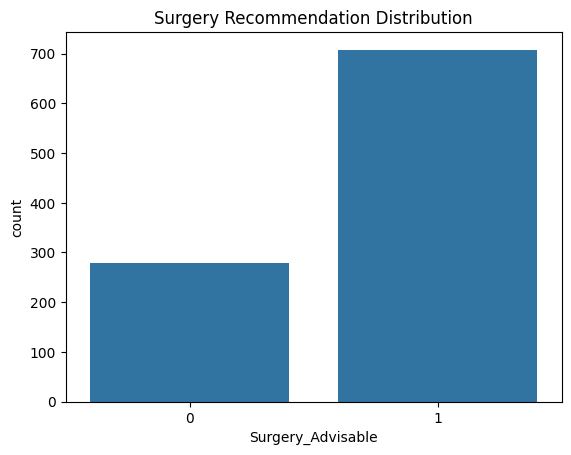

In [18]:
# Count of surgeries vs. no surgeries
sns.countplot(data=final_df, x="Surgery_Advisable")
plt.title("Surgery Recommendation Distribution")
plt.show()

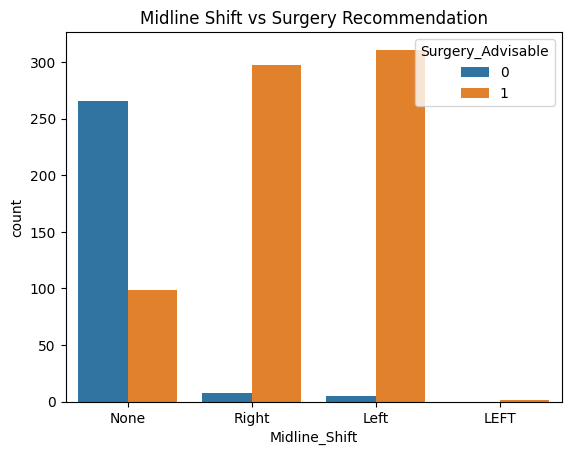

In [19]:
# Relationship between midline shift and surgery
sns.countplot(data=final_df, x="Midline_Shift", hue="Surgery_Advisable")
plt.title("Midline Shift vs Surgery Recommendation")
plt.show()

# Preprocessing Images


### Checking for empty or corrrupted images

In [21]:
import cv2
import os
import pandas as pd

In [22]:
valid_rows = []

for idx, row in final_df.iterrows():
    path = row["image_path"]
    if os.path.exists(path) and os.path.getsize(path) > 0:  # not empty
        img = cv2.imread(path)
        if img is not None:  # successfully read
            valid_rows.append(row)
        else:
            print(f"⚠️ Corrupted image (unreadable): {path}")
    else:
        print(f"⚠️ Missing or empty image: {path}")


final_df_valid = pd.DataFrame(valid_rows)

⚠️ Corrupted image (unreadable): images/771.jpg


In [25]:
final_df_valid.head()

,image_path,Midline_Shift,Surgery_Advisable
0,images/1.jpg,None,1
1,images/2.jpg,None,0
2,images/3.jpg,None,0
3,images/4.jpg,Right,1
4,images/5.jpg,None,0


### Skull Stripping

In [27]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm 

In [28]:
def skull_strip(image_path, save_folder):
    image_path = os.path.abspath(image_path)
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Otsu's thresholding for segmentation
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours (outer boundaries)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Select largest contour (brain region)
        c = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [c], -1, 255, thickness=cv2.FILLED)

        # Apply mask to keep only the brain region
        skull_stripped = cv2.bitwise_and(img, img, mask=mask)
    else:
        print(f"No contour detected: {image_path}")
        skull_stripped = img

    # Save processed image
    os.makedirs(save_folder, exist_ok=True)
    save_path = os.path.join(save_folder, os.path.basename(image_path))
    cv2.imwrite(save_path, skull_stripped)

    return save_path

In [29]:
def process_all_images(df, save_folder="processed_images"):
    updated_paths = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Skull Stripping"):
        path = row["image_path"]
        new_path = skull_strip(path, save_folder)
        updated_paths.append(new_path if new_path else path)

    df_new = df.copy()
    df_new["processed_image_path"] = updated_paths
    return df_new


In [30]:
df =  process_all_images(final_df_valid)

Skull Stripping: 100%|██████████| 986/986 [00:04<00:00, 224.27it/s]


In [31]:
df

,image_path,Midline_Shift,Surgery_Advisable,processed_image_path
0,images/1.jpg,None,1,processed_images/1.jpg
1,images/2.jpg,None,0,processed_images/2.jpg
2,images/3.jpg,None,0,processed_images/3.jpg
3,images/4.jpg,Right,1,processed_images/4.jpg
4,images/5.jpg,None,0,processed_images/5.jpg
...,...,...,...,...
982,images/983.jpg,Left,1,processed_images/983.jpg
983,images/984.jpg,None,1,processed_images/984.jpg
984,images/985.jpg,Right,1,processed_images/985.jpg
985,images/986.jpg,Left,1,processed_images/986.jpg


In [32]:
print(df["Surgery_Advisable"].value_counts())

Surgery_Advisable
1    707
0    279
Name: count, dtype: int64


In [33]:
print(df["Midline_Shift"].value_counts())

Midline_Shift
None     365
Left     315
Right    305
LEFT       1
Name: count, dtype: int64


In [34]:
# Normalize text
df["Midline_Shift"] = df["Midline_Shift"].str.strip().str.capitalize()

# Verify again
print(df["Midline_Shift"].value_counts())


Midline_Shift
None     365
Left     316
Right    305
Name: count, dtype: int64


In [35]:
df

,image_path,Midline_Shift,Surgery_Advisable,processed_image_path
0,images/1.jpg,None,1,processed_images/1.jpg
1,images/2.jpg,None,0,processed_images/2.jpg
2,images/3.jpg,None,0,processed_images/3.jpg
3,images/4.jpg,Right,1,processed_images/4.jpg
4,images/5.jpg,None,0,processed_images/5.jpg
...,...,...,...,...
982,images/983.jpg,Left,1,processed_images/983.jpg
983,images/984.jpg,None,1,processed_images/984.jpg
984,images/985.jpg,Right,1,processed_images/985.jpg
985,images/986.jpg,Left,1,processed_images/986.jpg


In [36]:
df["Has_Shift"] = df["Midline_Shift"].apply(
    lambda x: 0 if x == "None" else 1
)


In [37]:
midline_map = {"Left": 0, "Right": 1, "None": 2}
df["Midline_Shift_Label"] = df["Midline_Shift"].map(midline_map)

In [38]:
df


,image_path,Midline_Shift,Surgery_Advisable,processed_image_path,Has_Shift,Midline_Shift_Label
0,images/1.jpg,None,1,processed_images/1.jpg,0,2
1,images/2.jpg,None,0,processed_images/2.jpg,0,2
2,images/3.jpg,None,0,processed_images/3.jpg,0,2
3,images/4.jpg,Right,1,processed_images/4.jpg,1,1
4,images/5.jpg,None,0,processed_images/5.jpg,0,2
...,...,...,...,...,...,...
982,images/983.jpg,Left,1,processed_images/983.jpg,1,0
983,images/984.jpg,None,1,processed_images/984.jpg,0,2
984,images/985.jpg,Right,1,processed_images/985.jpg,1,1
985,images/986.jpg,Left,1,processed_images/986.jpg,1,0


In [39]:
output_path = "cleaned_dataset.csv"
df.to_csv(output_path, index=False)